# Factory Electric Consumption Prediction

## Objective
- Predict Factory Electric Consumption using a regression model.
- Training data: ~ 13,800 records
- Test data: ~ 2,160 records
- Evaluation metric: RMSE 

## Libraries Used

In [1]:
import pandas as pd
import numpy as np
import os
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## Data Exploration

In [2]:
# Upload the data
train_df = pd.read_csv("Data/train_df.csv")
test_df = pd.read_csv("Data/test_df.csv")

# Convert Date column to datetime
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

# Statistics
display(train_df.describe())
display(train_df.info())

,Date,Electric_Consumption,Factor_A,Factor_B,Factor_C,Factor_D,Factor_E,Factor_F
count,13872,13872.000000,13872.000000,13872.000000,13872.000000,13872.000000,13872.000000,13872.000000
mean,2023-10-16 23:30:00,5.893120,2.262227,19.977867,40.332796,145.005668,0.209435,42.522214
min,2023-01-01 00:00:00,-0.009717,-74.220598,-5.422289,3.249366,-1380.363752,0.000000,0.000000
25%,2023-05-25 11:45:00,0.000000,1.105756,13.088434,20.396742,106.883078,0.000000,0.579665
50%,2023-10-16 23:30:00,0.086858,1.995936,20.187978,34.024351,138.044038,0.000000,1.981719
75%,2024-03-09 11:15:00,13.512742,3.261530,26.994172,57.191932,209.901463,0.000000,60.123072
max,2024-07-31 23:00:00,21.360638,8.392045,44.036205,101.706771,312.895406,31.000006,31839.840610
std,NaN,7.355969,1.457234,9.607866,24.324671,94.993992,1.691576,280.466514


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13872 entries, 0 to 13871
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  13872 non-null  datetime64[ns]
 1   Electric_Consumption  13872 non-null  float64       
 2   Factor_A              13872 non-null  float64       
 3   Factor_B              13872 non-null  float64       
 4   Factor_C              13872 non-null  float64       
 5   Factor_D              13872 non-null  float64       
 6   Factor_E              13872 non-null  float64       
 7   Factor_F              13872 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 867.1 KB


None

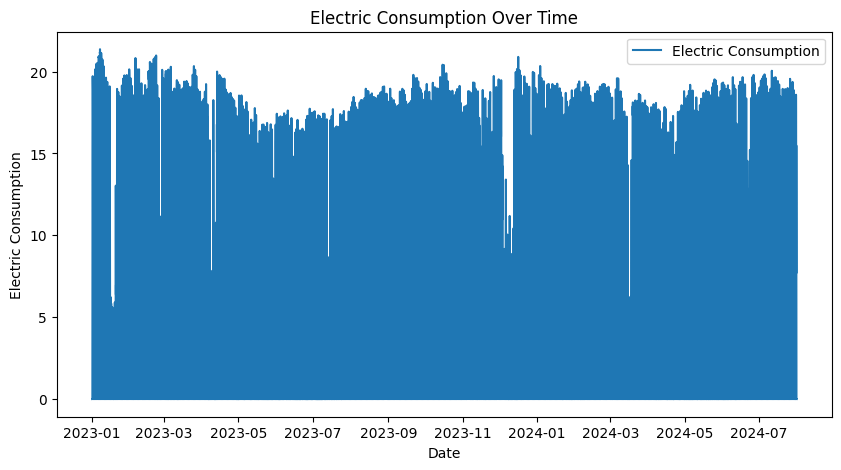

In [3]:
# Plot the Electric Consumption over time
plt.figure(figsize=(10, 5))
plt.plot(train_df['Date'], train_df['Electric_Consumption'], label='Electric Consumption')
plt.title('Electric Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Electric Consumption')
plt.legend()
plt.show()

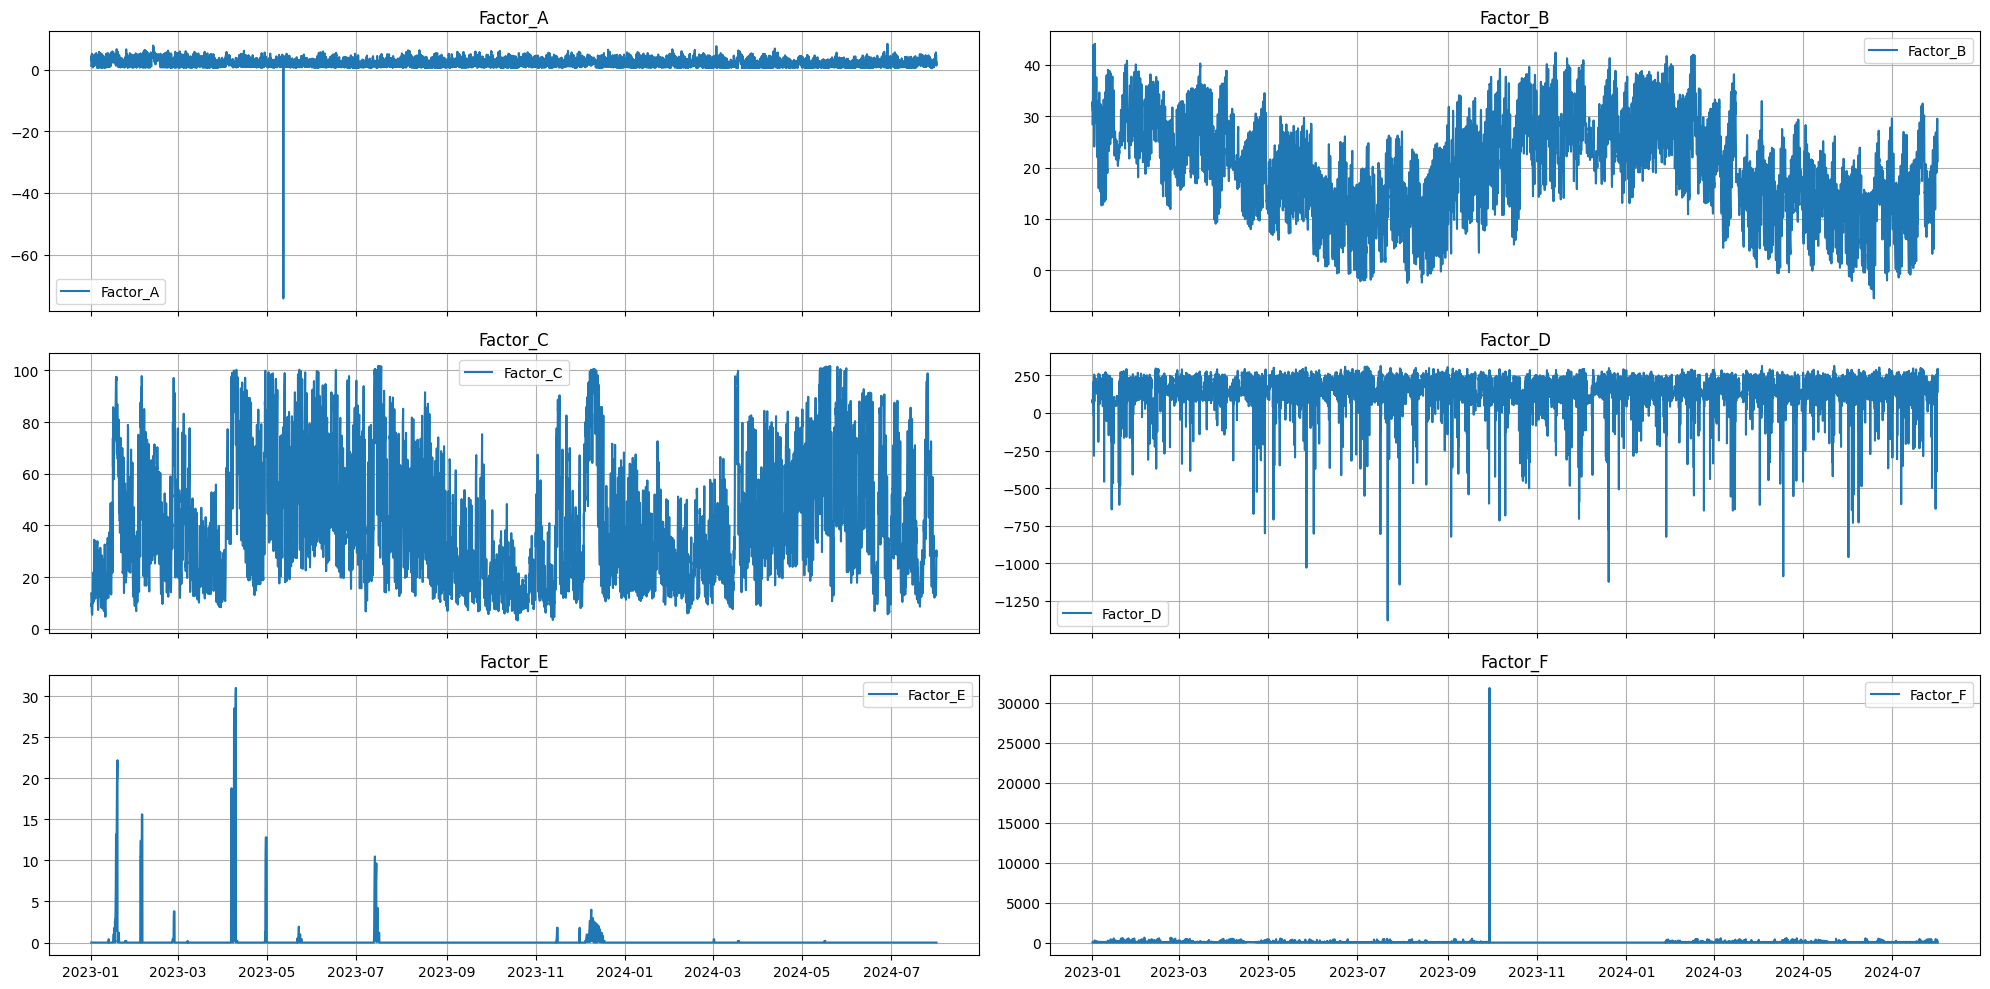

In [4]:
# Feature Visualization: create subplots for different factors
fig, axs = plt.subplots(3, 2, figsize=(20, 10), sharex=True)
axs = axs.flatten()

factors = ['Factor_A', 'Factor_B', 'Factor_C', 'Factor_D', 'Factor_E', 'Factor_F']

for i, factor in enumerate(factors):
    axs[i].plot(train_df['Date'], train_df[factor], label=factor)
    axs[i].set_title(factor)
    axs[i].legend()
    axs[i].grid(True)
plt.tight_layout()
plt.show()

In [5]:
#Feature Extraction
for df in [train_df, test_df]:
    df['Hour'] = df['Date'].dt.hour
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day

# Drop the original Date column
features = ['Factor_A', 'Factor_B', 'Factor_C', 'Factor_D', 'Factor_E', 'Factor_F', 'Hour', 'DayOfWeek', 'Month', 'Day']

display(train_df.head())

,Date,Electric_Consumption,Factor_A,Factor_B,Factor_C,Factor_D,Factor_E,Factor_F,Hour,DayOfWeek,Month,Day
0,2023-01-01 00:00:00,0.000000,1.242130,28.419739,13.720397,79.840600,0.0,2.386157,0,6,1,1
1,2023-01-01 01:00:00,0.000000,1.861285,29.840759,12.537668,86.424903,0.0,1.473256,1,6,1,1
2,2023-01-01 02:00:00,0.000000,4.212674,32.778036,9.408667,72.082793,0.0,1.583711,2,6,1,1
3,2023-01-01 03:00:00,0.000000,4.025251,32.624700,9.035601,73.825705,0.0,1.706656,3,6,1,1
4,2023-01-01 04:00:00,-0.000267,3.122659,31.931245,9.235502,66.823956,0.0,0.987048,4,6,1,1


In [6]:
# Missing Values Check
train_df.isnull().sum()

Date                    0
Electric_Consumption    0
Factor_A                0
Factor_B                0
Factor_C                0
Factor_D                0
Factor_E                0
Factor_F                0
Hour                    0
DayOfWeek               0
Month                   0
Day                     0
dtype: int64

###  Models Training and Evaluation

In [7]:
# Dataset Preparation
X = train_df[features]
y = train_df['Electric_Consumption']
X_test = test_df[features]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Helper Functions
def rmse_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse
    
def plot_feature_importance(model, features, model_name):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importances: {model_name}")
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=45)
    plt.tight_layout()
    plt.show()
    
def submission_dataset(predictions, name): 
    name = name.replace(" ", "_")
    output_file = f"Data\\submission_{name}.csv"
    if os.path.exists(output_file):
        os.remove(output_file)
    submission = pd.DataFrame({'Date': test_df['Date'], 'Electric_Consumption': predictions})
    submission.to_csv(output_file, index=False)

    # print(f"File submission_{name}.csv salvato con successo!")

In [9]:
# Models to Compare
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
}

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 10, None],
    'min_samples_split': [2, 5],
}

xgb_param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.05],
    'max_depth': [4, 6, 8],
    'subsample': [0.8, 1],
}


############    Training Linear Regression    ############
Linear Regression Cross-validated RMSE: 8.04 ± 4.55
Linear Regression RMSE: 5.26

############    Training Random Forest    ############
Random Forest Cross-validated RMSE: 2.57 ± 0.53
Performing grid search for Random Forest ...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Random Forest parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest RMSE: 1.64


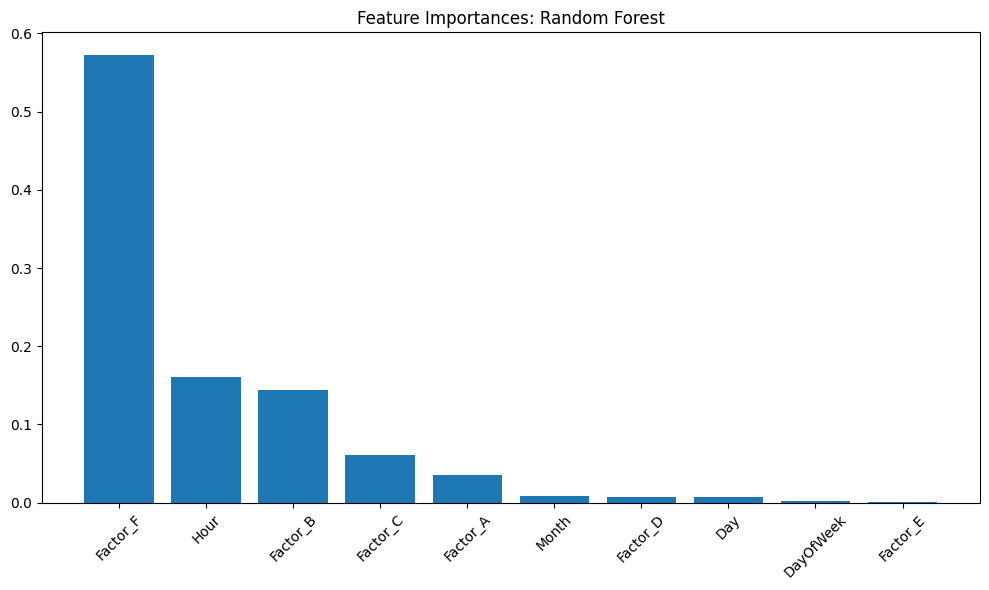


############    Training XGBoost    ############
XGBoost Cross-validated RMSE: 2.73 ± 0.54
Performing grid search for XGBoost ...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best XGBoost parameters: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 1000, 'subsample': 0.8}
XGBoost RMSE: 1.46


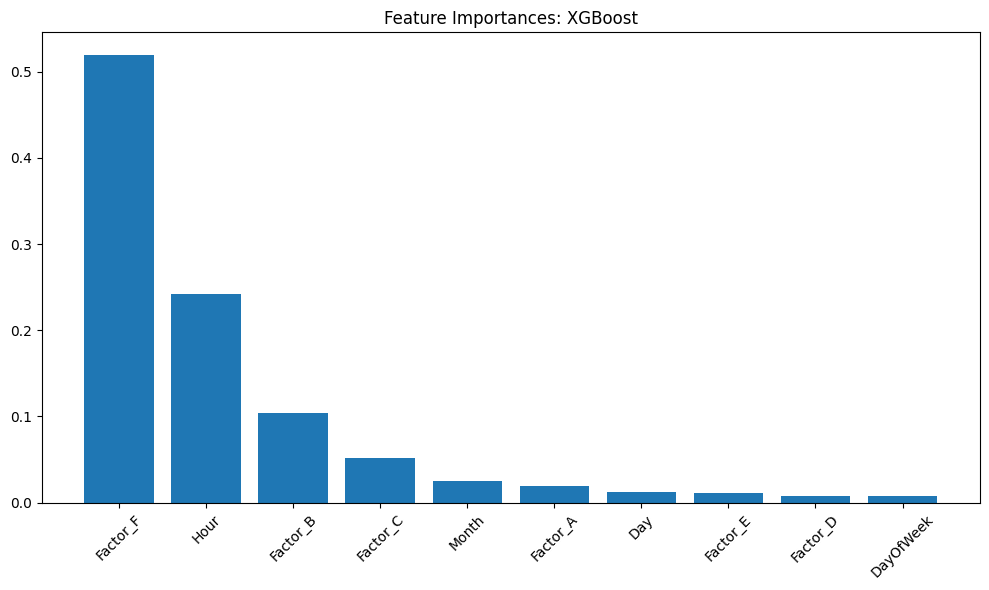

In [10]:
# Training, Validation, and Results
for name, model in models.items():

    print(f"\n############    Training {name}    ############")

    # Cross validation RMSE 
    cv_rmse = rmse_cv(model, X, y)
    print(f"{name} Cross-validated RMSE: {cv_rmse.mean():.2f} ± {cv_rmse.std():.2f}")

    if name == "Random Forest": param_grid = rf_param_grid
    elif name == "XGBoost": param_grid = xgb_param_grid
    else: param_grid = None

    if param_grid:
        
        # Hyperparameter tuning using GridSearchCV
        print(f"Performing grid search for {name} ...")
        grid_model = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

        # Fit the model 
        grid_model.fit(X_train, y_train)
        best_model = grid_model.best_estimator_
        print(f"Best {name} parameters: {grid_model.best_params_}")

    else:
        # Fit the model without hyperparameter tuning
        model.fit(X_train, y_train)
        best_model = model

    val_predictions = best_model.predict(X_val)
    val_predictions = np.clip(val_predictions, 0, None)
    print(f"{name} RMSE: {np.sqrt(mean_squared_error(y_val, val_predictions)):.2f}")

    # Feature Importance
    if hasattr(best_model, 'feature_importances_'):
        plot_feature_importance(best_model, features, name)

    # I attempted to improve model performance by removing less important features based on feature importance scores. 
    # Specifically, I experimented with thresholds of 0.05, 0.02, and 0.01 to filter out features with low importance values. 
    # After selecting the most relevant features using each threshold, I retrained the model and evaluated the new RMSE. 
    # However, in all cases, the RMSE increased compared to the original model using all features. 
    # As a result, I decided to keep the full feature set for training, as removing the lower-importance features consistently led to worse performance.
    
    #     important_features = [feature for feature, importance in zip(features, best_model.feature_importances_) 
    #     if importance > 0.01]

    #     if len(important_features) > 0:
    #         # New dataset with important features
    #         X_train_imp = X_train[important_features]
    #         X_val_imp = X_val[important_features]
    #         X_test_imp = X_test[important_features]

    #         # Re-train the model with important features
    #         best_model.fit(X_train_imp, y_train)
    #         val_predictions = best_model.predict(X_val_imp)
    #         print(f"RMSE with selected features: {np.sqrt(mean_squared_error(y_val, val_predictions)):.2f}")

    #         predictions = best_model.predict(X_test_imp)
    #     else:
    #         predictions = best_model.predict(X_test)
    # else:
    
    predictions = best_model.predict(X_test)

# predictions = np.clip(predictions, 0, None)
submission_dataset(predictions, name)